In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd

In [7]:
path= './data/'
df=pd.read_csv(path + 'Country_data.csv')
df_topics_linked = pd.read_csv(path + 'topics_linked.csv.xz')

In [8]:
df_topics_linked.head()

,index,Geography.Regions.Asia.Central Asia,Geography.Regions.Europe.Eastern Europe,History and Society.Military and warfare,Culture.Media.Television,History and Society.Education,Culture.Media.Books,Geography.Regions.Africa.Africa*,Culture.Visual arts.Architecture,Culture.Biography.Women,...,Geography.Regions.Asia.West Asia,STEM.Chemistry,Geography.Regions.Europe.Northern Europe,Culture.Media.Video games,Geography.Regions.Asia.Southeast Asia,Culture.Media.Entertainment,Culture.Media.Music,Geography.Regions.Asia.Asia*,Geography.Regions.Asia.North Asia,qid
0,Rosmalen,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q2001490
1,Commelinales,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q290349
2,Transport_in_Honduras,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q1130638
3,QuakeC,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q2122062
4,Food_writing,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q5465542


In [3]:
df['Participatory Engagement']=df[['Civil Society Participation','Electoral Participation','Direct Democracy','Local Democracy']].mean(axis=1)
df['Democracy Score'] =df[['Representative Government','Fundamental Rights','Checks on Government','Impartial Administration','Participatory Engagement']].mean(axis=1)
df=df.replace("Republic of Korea", "South Korea")


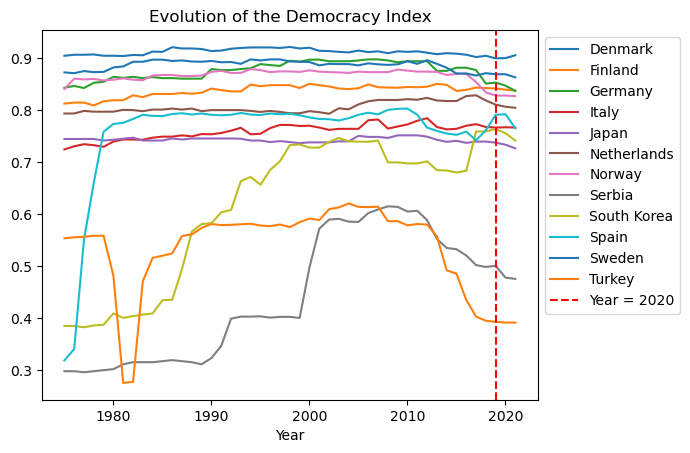

In [4]:
df.set_index('Year',inplace=True)
df.groupby('Country name')['Democracy Score'].plot(x='Year',legend=True)
plt.axvline(x = 2019, color = 'r',ls='--', label = 'Year = 2020')
plt.title('Evolution of the Democracy Index')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()
df.reset_index(inplace=True)

In [5]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries = countries.merge(df[df["Year"]==2020][['Country name','Democracy Score']],left_on='name',right_on='Country name', how='left')
countries.drop('Country name', inplace=True, axis=1)

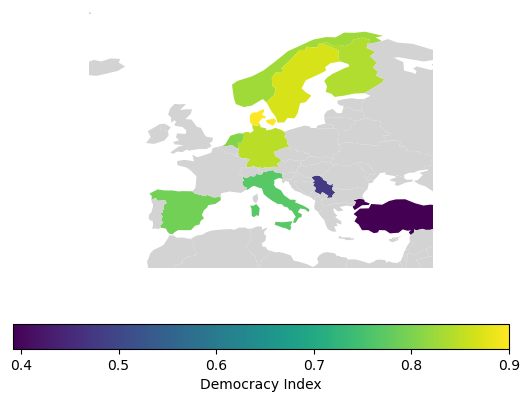

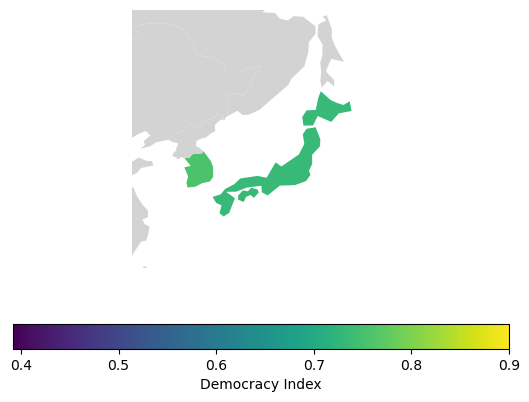

In [6]:
ax1=countries.plot(column='Democracy Score', legend=True,legend_kwds={'label': "Democracy Index",
                        'orientation': "horizontal"}, missing_kwds={'color': 'lightgrey'})
ax2=countries.plot(column='Democracy Score', legend=True,legend_kwds={'label': "Democracy Index",
                        'orientation': "horizontal"}, missing_kwds={'color': 'lightgrey'})
ax1.set_xlim(-20,40)
ax1.set_ylim(30,75)
ax1.set_axis_off()

ax2.set_xlim(120,150)
ax2.set_ylim(25,55)
ax2.set_axis_off()
plt.show()

